<a href="https://colab.research.google.com/github/snow-white2024/AIFFEL_quest_cr/blob/master/%EC%9D%B8%EB%AC%BC%EC%82%AC%EC%A7%84%EC%9D%84_%EB%A7%8C%EB%93%A4%EC%96%B4_%EB%B3%B4%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. 인물사진을 만들어 보자 [프로젝트]

셀로우 포커스 만들기 (1) 사진을 준비하자

In [8]:
import urllib
import cv2
import numpy as np
from matplotlib import pyplot as plt

print('슝=3')

슝=3


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
image_path = '/content/drive/My Drive/test cut1.jpeg'
img_orig = cv2.imread(image_path)
print(img_orig.shape)

(1280, 960, 3)


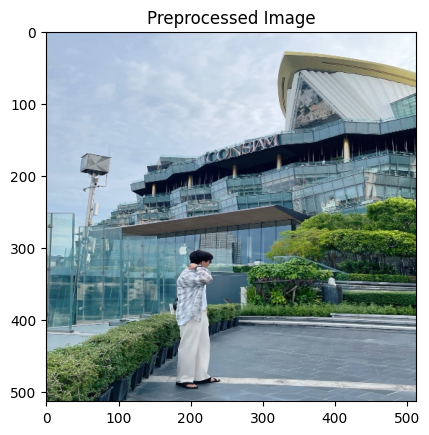

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    # 이미지 로드
    image = cv2.imread(image_path)
    # 색상 공간을 BGR에서 RGB로 변환
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 이미지 크기 조정 (필요시)
    image = cv2.resize(image, (513, 513))  # DeepLabV3+ 모델에 맞게 크기 조정
    return image

# 이미지 로드 및 전처리
image = load_and_preprocess_image(image_path)

# 전처리된 이미지 출력
plt.imshow(image)
plt.title("Preprocessed Image")
plt.show()


In [14]:
import os
import tarfile
import tensorflow as tf
import urllib.request

# 모델 다운로드 경로
MODEL_URL = "http://download.tensorflow.org/models/deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz"
MODEL_DIR = "/content/deeplab_model"
TARBALL_NAME = "deeplab_model.tar.gz"

# 모델 저장 폴더 생성
os.makedirs(MODEL_DIR, exist_ok=True)
tarball_path = os.path.join(MODEL_DIR, TARBALL_NAME)

# 모델 다운로드
if not os.path.exists(tarball_path):
    print("Downloading model...")
    urllib.request.urlretrieve(MODEL_URL, tarball_path)
    print("Download complete.")

# 압축 해제
print("Extracting model...")
with tarfile.open(tarball_path) as tar:
    tar.extractall(path=MODEL_DIR)
print("Model extracted.")


Download complete.
Extracting model...
Model extracted.


In [15]:
import cv2
import numpy as np
import tensorflow as tf

# 모델 파일 경로
MODEL_PATH = "/content/deeplab_model/deeplabv3_mnv2_cityscapes_train/frozen_inference_graph.pb"

# 그래프 로드 함수
def load_frozen_graph(model_path):
    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(model_path, "rb") as f:
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name="")
    return graph

# 모델 로드
deeplab_graph = load_frozen_graph(MODEL_PATH)
print("DeepLabV3+ 모델 로드 완료!")


DeepLabV3+ 모델 로드 완료!


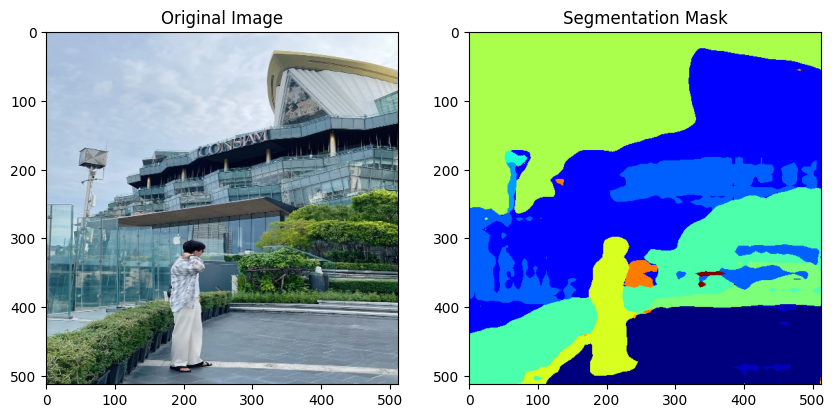

In [16]:
def run_segmentation(image, graph):
    input_tensor_name = "ImageTensor:0"
    output_tensor_name = "SemanticPredictions:0"

    # 세션 실행
    with tf.compat.v1.Session(graph=graph) as sess:
        input_tensor = graph.get_tensor_by_name(input_tensor_name)
        output_tensor = graph.get_tensor_by_name(output_tensor_name)

        # 이미지 크기 조정
        resized_image = cv2.resize(image, (513, 513))
        batch_seg_map = sess.run(output_tensor, feed_dict={input_tensor: [resized_image]})

        # 마스크 생성
        mask = batch_seg_map[0]

    return mask

# 세그멘테이션 실행
mask = run_segmentation(image, deeplab_graph)

# 결과 출력
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="jet")
plt.title("Segmentation Mask")
plt.show()


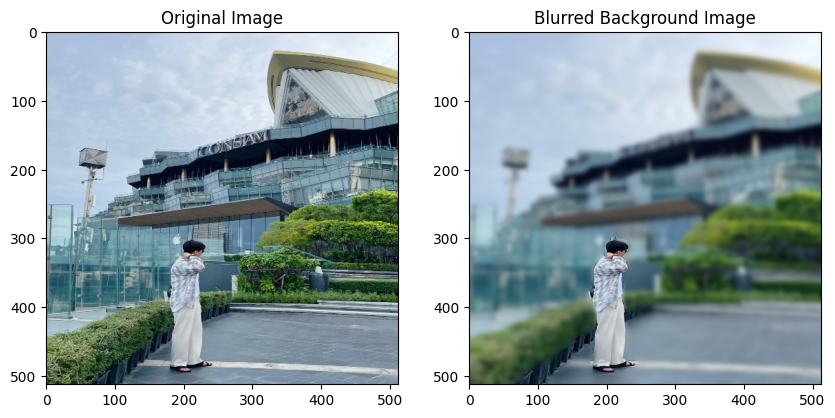

In [23]:
def apply_blur_background(image, mask):
    # 마스크 크기를 원본 이미지 크기로 조정
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # 마스크 이진화 (사람 부분 = 1, 배경 부분 = 0)
    binary_mask = (mask_resized == 11).astype(np.uint8)  # 15는 사람 클래스 ID

    # 배경 블러 처리
    blurred_background = cv2.GaussianBlur(image, (21, 21), 0)

    # 마스크를 3채널로 확장
    binary_mask_3ch = np.stack([binary_mask] * 3, axis=-1)

    # 배경을 블러 처리한 이미지와 사람을 합성
    result = (image * binary_mask_3ch) + (blurred_background * (1 - binary_mask_3ch))

    return result.astype(np.uint8)

# 블러 처리된 이미지 생성
blurred_image = apply_blur_background(image, mask)

# 결과 출력
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(blurred_image)
plt.title("Blurred Background Image")
plt.show()


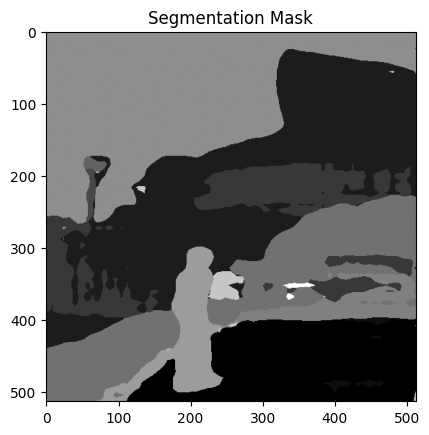

In [21]:
plt.imshow(mask, cmap="gray")
plt.title("Segmentation Mask")
plt.show()

In [20]:
print(np.unique(mask))  # 사용된 클래스 ID 출력


[ 0  1  2  4  5  7  8  9 10 11 13 14 18]


사용된 클래스 ID: [ 0  1  2  4  5  7  8  9 10 11 13 14 18]


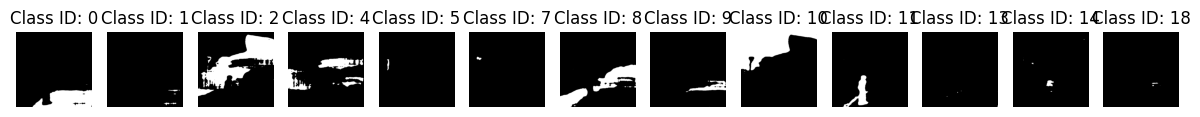

In [22]:
unique_classes = np.unique(mask)
print("사용된 클래스 ID:", unique_classes)

# 특정 클래스 ID에 해당하는 영역을 시각화
fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 5))
for i, class_id in enumerate(unique_classes):
    class_mask = (mask == class_id).astype(np.uint8)
    axes[i].imshow(class_mask, cmap="gray")
    axes[i].set_title(f"Class ID: {class_id}")
    axes[i].axis("off")

plt.show()
